Автор: Лейман М.А.  
Дата создания: 14.06.2025 

# Итоговая аттестация 
### __проект 7:__   _Семантическая сегментация с помощью U-Net на уличных сценах_  



## Задание  
-​ Реализация U-Net или DeepLabv3 для пиксельной классификации дорожных сцен (дорог, пешеходов, транспортных средств и пр)  

-​ Оценка, например, на Cityscapes или Pascal VOC.  

-​ Визуализация масок сегментаций, наложенных на исходные  изображения, с помощью OpenCV  


## Импорты 

In [ ]:
from attestation import CityscapesFlatDataset, CityscapesFlatDataset2, merge_folders, train_model,\
                        prepare_cityscapes_loaders, visualize_segmentation, emty_cache, visualize_image_and_mask, prediction_mask


from data.dataset import CityscapesFlatDataset, CityscapesFlatDataset2, prepare_cityscapes_loaders
from utils.utils import emty_cache, visualize_image_and_mask, visualize_segmentation, merge_folders
from model.train import train_model
from model.predict import prediction_mask

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 
import warnings
import copy
import torch.optim as optim
import time
import numpy as np
import torch
from torch.utils.data import random_split, DataLoader
from torchsummary import summary
from tqdm import tqdm
from torch.optim import lr_scheduler
from matplotlib import rcParams
import shutil
from PIL import Image
from torch.utils.data import Dataset
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import gc

warnings.filterwarnings("ignore")
np.random.seed(42)
#set_global_seed(42)
rcParams['figure.figsize'] = (14,6)

## Параметры

In [2]:
# Классы
CITYSCAPES_PALETTE = np.array([
    [0, 0, 0],      # ФОН
    [128, 64,128],  # road
    [244, 35,232],  # sidewalk
    [70, 70, 70],   # building
    [102,102,156],  # wall
    [190,153,153],  # fence
    [153,153,153],  # pole
    [250,170, 30],  # traffic light
    [220,220,  0],  # traffic sign
    [107,142, 35],  # vegetation
    [152,251,152],  # terrain
    [70,130,180],   # sky
    [220, 20, 60],  # person
    [255,  0,  0],  # rider
    [0,  0,142],    # car
    [0,  0, 70],    # truck
    [0, 60,100],    # bus
    [0, 80,100],    # train
    [0,  0,230],    # motorcycle
    [119, 11, 32],  # bicycle
])


In [3]:
# устанавливаем device если gpu или cpu


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.6.0+cu124
версия  cuDNN:           90100
Tue Jun 17 14:42:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
|  0%   53C    P5             24W /  170W |     616MiB /  12288MiB |     25%      Default |
|                                         

## Загрузка данных 

### Датасет

In [4]:
# Путь к папкам с исходными данными
images_root = './dataset/images'
targets_root = './dataset/targets'

# Папки для объединённых данных
images_merged = './dataset/images_merged'
targets_merged = './dataset/targets_merged'

# merge_folders(images_root, images_merged)
# merge_folders(targets_root, targets_merged)


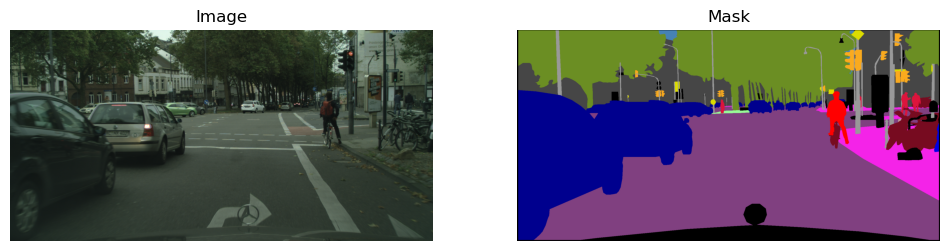

In [5]:
root_dir = './dataset'
dataset = CityscapesFlatDataset(root_dir)
# Использование с вашим датасетом
image, mask = dataset[10]
visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

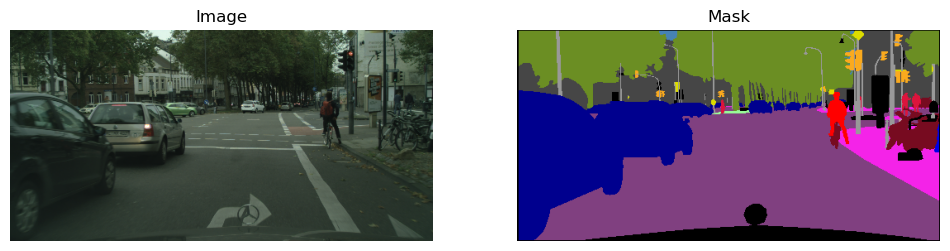

In [6]:
root_dir = './dataset'
dataset = CityscapesFlatDataset2(root_dir)
# Использование с вашим датасетом
image, mask = dataset[10]

visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

In [7]:
print(np.unique(mask))


[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 18 19]


### Разделение датасета

In [8]:
batch_size = 16
size = 256, 512

train_loader, val_loader, train_dataset, val_dataset = prepare_cityscapes_loaders(
            CityscapesFlatDataset2, './dataset', size, batch_size=batch_size
        )

# Размеры тензоров
for images, masks in train_loader:
    print(images.shape)  # [batch_size, 3, H, W]
    print(masks.shape)   # [batch_size, 1, H, W]
    masks = masks.squeeze(1)  # [batch_size, H, W]
    break



Train size: 2780, Validation size: 695
torch.Size([16, 3, 256, 512])
torch.Size([16, 256, 512])


## Модели

### 2) __DeepLabV3Plus__  

In [9]:
import segmentation_models_pytorch as smp
import torch

# Параметры модели
ENCODER = "resnet34"           # можно выбрать другой, например 'resnet50'
ENCODER_WEIGHTS = "imagenet"   # предобученные веса энкодера
CLASSES = 20                   # количество классов сегментации (например, для Cityscapes)
ACTIVATION = None              # активация на выходе (например, 'softmax' или None)

# Создаем модель DeepLabV3+
model_deeplab = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
    activation=ACTIVATION,
)


## Обучение

### 2) DeepLabV3Plus

Epoch 1 Val: 100%|██████████| 44/44 [00:47<00:00,  1.08s/it, acc=0.857, iou=0.386, loss=0.487]


Epoch 1 summary: Train Loss: 0.7740, Acc: 0.7145, IoU: 0.3178 | Val Loss: 0.4276, Acc: 0.8601, IoU: 0.4004
Сохранена лучшая модель 1 с val IoU: 0.4004


Epoch 2 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.885, iou=0.422, loss=0.5]  


Epoch 2 summary: Train Loss: 0.5313, Acc: 0.8288, IoU: 0.3763 | Val Loss: 0.3643, Acc: 0.8850, IoU: 0.4274
Сохранена лучшая модель 2 с val IoU: 0.4274


Epoch 3 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.872, iou=0.381, loss=0.474]


Epoch 3 summary: Train Loss: 0.4635, Acc: 0.8484, IoU: 0.4046 | Val Loss: 0.3952, Acc: 0.8711, IoU: 0.4185


Epoch 4 Val: 100%|██████████| 44/44 [00:47<00:00,  1.08s/it, acc=0.877, iou=0.427, loss=0.489]


Epoch 4 summary: Train Loss: 0.4188, Acc: 0.8634, IoU: 0.4348 | Val Loss: 0.3991, Acc: 0.8788, IoU: 0.4225


Epoch 5 Val: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, acc=0.889, iou=0.398, loss=0.425]


Epoch 5 summary: Train Loss: 0.3925, Acc: 0.8721, IoU: 0.4506 | Val Loss: 0.3478, Acc: 0.8897, IoU: 0.4403
Сохранена лучшая модель 5 с val IoU: 0.4403


Epoch 6 Val: 100%|██████████| 44/44 [00:47<00:00,  1.08s/it, acc=0.901, iou=0.438, loss=0.39] 


Epoch 6 summary: Train Loss: 0.3352, Acc: 0.8885, IoU: 0.4885 | Val Loss: 0.3113, Acc: 0.9011, IoU: 0.4778
Сохранена лучшая модель 6 с val IoU: 0.4778


Epoch 7 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.902, iou=0.461, loss=0.377]


Epoch 7 summary: Train Loss: 0.3076, Acc: 0.9001, IoU: 0.5124 | Val Loss: 0.3069, Acc: 0.9022, IoU: 0.4859
Сохранена лучшая модель 7 с val IoU: 0.4859


Epoch 8 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.903, iou=0.442, loss=0.383]


Epoch 8 summary: Train Loss: 0.2883, Acc: 0.9044, IoU: 0.5298 | Val Loss: 0.3065, Acc: 0.9036, IoU: 0.4844


Epoch 9 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.905, iou=0.451, loss=0.37] 


Epoch 9 summary: Train Loss: 0.2767, Acc: 0.9089, IoU: 0.5420 | Val Loss: 0.3042, Acc: 0.9059, IoU: 0.4897
Сохранена лучшая модель 9 с val IoU: 0.4897


Epoch 10 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.905, iou=0.459, loss=0.364]


Epoch 10 summary: Train Loss: 0.2688, Acc: 0.9110, IoU: 0.5462 | Val Loss: 0.3030, Acc: 0.9064, IoU: 0.4918
Сохранена лучшая модель 10 с val IoU: 0.4918


Epoch 11 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.906, iou=0.433, loss=0.365]


Epoch 11 summary: Train Loss: 0.2571, Acc: 0.9147, IoU: 0.5574 | Val Loss: 0.2989, Acc: 0.9069, IoU: 0.4954
Сохранена лучшая модель 11 с val IoU: 0.4954


Epoch 12 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.907, iou=0.517, loss=0.361]


Epoch 12 summary: Train Loss: 0.2510, Acc: 0.9170, IoU: 0.5667 | Val Loss: 0.2984, Acc: 0.9076, IoU: 0.5007
Сохранена лучшая модель 12 с val IoU: 0.5007


Epoch 13 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.907, iou=0.433, loss=0.367]


Epoch 13 summary: Train Loss: 0.2474, Acc: 0.9177, IoU: 0.5686 | Val Loss: 0.2994, Acc: 0.9073, IoU: 0.4963


Epoch 14 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.907, iou=0.462, loss=0.358]


Epoch 14 summary: Train Loss: 0.2437, Acc: 0.9195, IoU: 0.5739 | Val Loss: 0.3001, Acc: 0.9075, IoU: 0.4973


Epoch 15 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.906, iou=0.459, loss=0.368]


Epoch 15 summary: Train Loss: 0.2399, Acc: 0.9197, IoU: 0.5797 | Val Loss: 0.3017, Acc: 0.9072, IoU: 0.4986


Epoch 16 Val: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it, acc=0.907, iou=0.488, loss=0.363]


Epoch 16 summary: Train Loss: 0.2364, Acc: 0.9209, IoU: 0.5814 | Val Loss: 0.3006, Acc: 0.9077, IoU: 0.4992


Epoch 17 Val: 100%|██████████| 44/44 [00:47<00:00,  1.08s/it, acc=0.907, iou=0.487, loss=0.363]


Epoch 17 summary: Train Loss: 0.2351, Acc: 0.9218, IoU: 0.5863 | Val Loss: 0.3008, Acc: 0.9081, IoU: 0.4991


Epoch 18 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.908, iou=0.488, loss=0.364]


Epoch 18 summary: Train Loss: 0.2354, Acc: 0.9217, IoU: 0.5823 | Val Loss: 0.3001, Acc: 0.9085, IoU: 0.4991


Epoch 19 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.908, iou=0.487, loss=0.369]


Epoch 19 summary: Train Loss: 0.2332, Acc: 0.9219, IoU: 0.5892 | Val Loss: 0.2992, Acc: 0.9085, IoU: 0.4982


Epoch 20 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.907, iou=0.489, loss=0.363]


Epoch 20 summary: Train Loss: 0.2325, Acc: 0.9226, IoU: 0.5865 | Val Loss: 0.3007, Acc: 0.9080, IoU: 0.4997


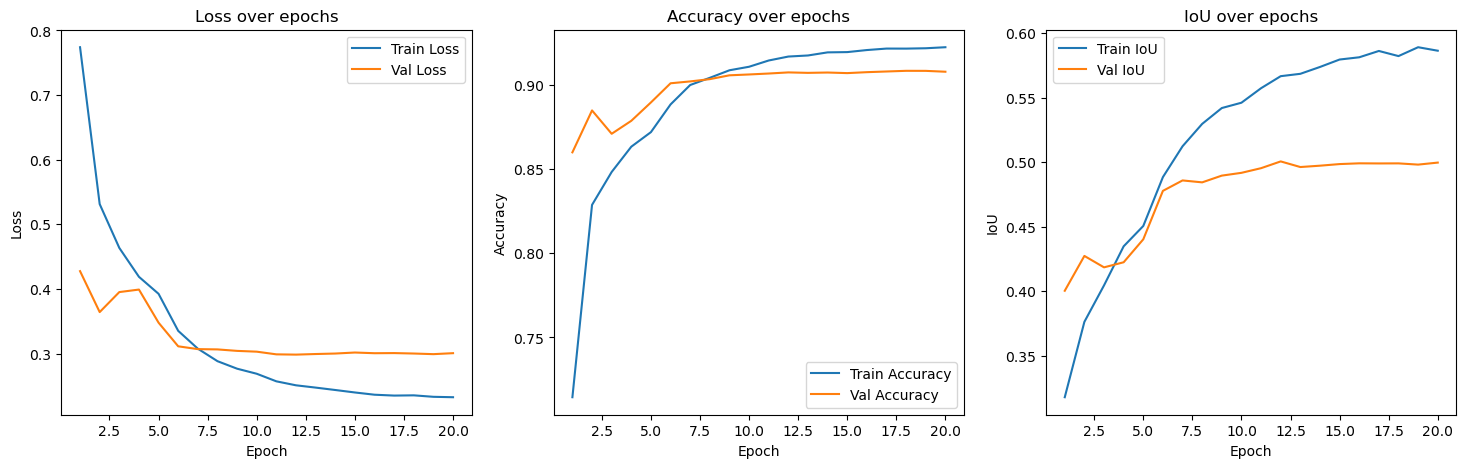

In [ ]:
model_deeplab.load_state_dict(torch.load('models/deeplab_model2.pth', map_location=torch.device('cpu'))) 
emty_cache()
optimizer = torch.optim.Adam(model_deeplab.parameters(), lr=0.0003)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)




train_model(model_deeplab, train_loader, val_loader, optimizer, device, num_epochs=20, scheduler=scheduler, save_path='models/deeplab_model2.pth')

## Использование модели

In [ ]:
model_deeplab.load_state_dict(torch.load('models/deeplab_model2.pth', map_location=torch.device(device))) 
model_deeplab.eval();
model_deeplab = model_deeplab.to(device)

path_img = './dataset/images2/train/hamburg/hamburg_000000_008494_leftImg8bit.png'



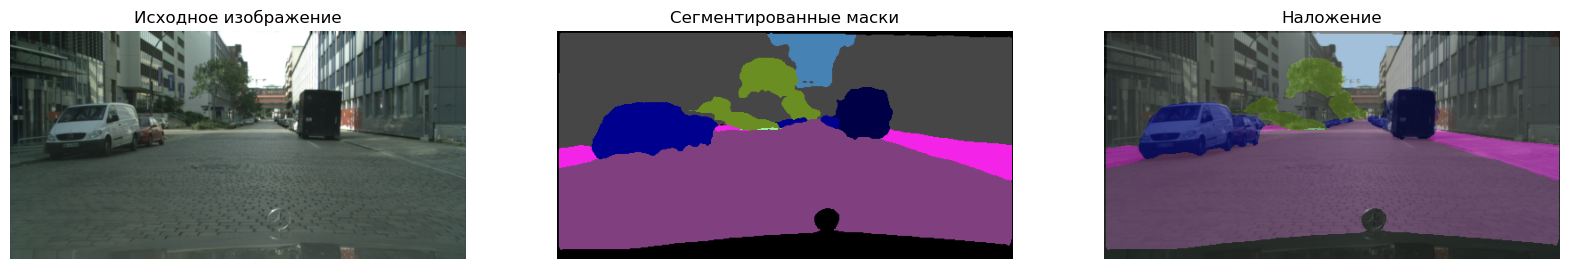

In [ ]:
img, prediction = prediction_mask(path_img, model_deeplab)
visualize_segmentation(img, prediction, CITYSCAPES_PALETTE)